<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto.

Se utilizará la biografría de María Antonieta para generar los embeddings, es decir, que los vectores tendrán la forma en función de como el autor Zweig Stefan narró la historia.

Se espera encontrar palabras similares cercanas en el plot de embeddings entrenados.

In [1]:
!pip install PyPDF2 -qq
!pip install pycryptodome==3.15.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.8 MB/s eta 0:00:00


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import PyPDF2

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset el texto de una biografía en pdf de María Antonieta de Austria, reina consorte de Francia.

In [34]:
# creating a pdf reader object
reader = PyPDF2.PdfReader('./Maria_Antonieta-Zweig_Stefan.pdf')

# print the number of pages in pdf file
print(len(reader.pages))

# print the text of the first page
print(reader.pages[0].extract_text())

265
LLLIIIBBBRRROOOdddooottt...cccooommm 
Stefan Zweig  
María Antonieta   
INDICE  
          Pagina  
 
Introducción          2 
Casan a una niña         4 
Secreto de alcoba         14 
Presentación en Versalles        20 
La lucha por un saludo        26 
La conquista de París        35 
«Le Roi est m ort, vive le Roi! »      40 
Retrato de una pareja regia        45 
La reina del rococó         52 
Trianón          60 
La nueva sociedad         67 
La visita del hermano        72 
Maternidad          77 
La reina se hace impopular        82 
Un rayo en el teatro rococ ó       89 
El asunto del collar         97 
Proceso y sentencia         107 
Despierta el pueblo, despierta la reina      114 
El verano de la decisión        118 
Huyen los amigos         123 
Aparece el amigo         128 
¿Lo era o no lo era?         134 
La última no che en Versalles       140 
El carro fúnebre de la monarquía       146 
Examen de conciencia        150 
Mirabeau          156 
Se prepara la huida 

In [55]:
texto_raw = ''

# Tomamos el texto a partir de la segunda página para evitar el índice
for p in reader.pages[1:]:
  texto_raw = texto_raw + p.extract_text()

In [56]:
# Un vistazo al texto obtenido
texto_raw

'La gran infamia         234 \nComienza el proceso        240 \nLa vista          243 \nEl último viaje         252 \nLa endecha fúnebre         256 \nNota del autor         259 \nCuadro cronológico         263 \n \nINTRODUCCIÓN  \nEscribir la historia de l a reina María Antonieta es volver a abrir un proceso más que \nsecular, en el cual acusadores y defensores se contradicen mutuamente del modo más \nviolento. Del tono apasionado de la discusión son culpables los acusadores. Para herir a la \nrealeza, la Revoluci ón tenía que atacar a la reina, y en la reina, a la mujer. Ahora bien. \nveracidad y política habitan raramente bajo el mismo techo, y allí donde se traza una ima -\ngen con fines demagógicos, es de esperar poca rectitud de los siervos complacientes de la \nopini ón pública. No se ahorró nin guna difamación contra María Antonieta. ningún medio \npara llevarla a la guillotina: todo vicio. toda depravación moral, toda suerte de \nperversidad fueron atribuidos sin vacilar a la 

Todavía se observa una porción del índice que vamos a descartar en próximos pasos

In [57]:
# Cantidad de caracteres
texto_raw.__len__()

1094614

In [58]:
# Cantidad de palabras aproximadas
texto_raw.split().__len__()

189423

In [59]:
# Cantidad de palabras unicas
set(texto_raw.split()).__len__()

31918

In [60]:
# Se reemplazan caracteres especiales
texto = texto_raw.replace('´ ','').replace('´','').replace('˜ n','ñ').replace('-\n','').replace('ı','i').replace('\n',' ')

In [61]:
texto

'La gran infamia         234  Comienza el proceso        240  La vista          243  El último viaje         252  La endecha fúnebre         256  Nota del autor         259  Cuadro cronológico         263    INTRODUCCIÓN   Escribir la historia de l a reina María Antonieta es volver a abrir un proceso más que  secular, en el cual acusadores y defensores se contradicen mutuamente del modo más  violento. Del tono apasionado de la discusión son culpables los acusadores. Para herir a la  realeza, la Revoluci ón tenía que atacar a la reina, y en la reina, a la mujer. Ahora bien.  veracidad y política habitan raramente bajo el mismo techo, y allí donde se traza una ima gen con fines demagógicos, es de esperar poca rectitud de los siervos complacientes de la  opini ón pública. No se ahorró nin guna difamación contra María Antonieta. ningún medio  para llevarla a la guillotina: todo vicio. toda depravación moral, toda suerte de  perversidad fueron atribuidos sin vacilar a la louve autrichienne 

In [62]:
# Quitamos la porcion de indice
texto = texto[222:]
texto

'Escribir la historia de l a reina María Antonieta es volver a abrir un proceso más que  secular, en el cual acusadores y defensores se contradicen mutuamente del modo más  violento. Del tono apasionado de la discusión son culpables los acusadores. Para herir a la  realeza, la Revoluci ón tenía que atacar a la reina, y en la reina, a la mujer. Ahora bien.  veracidad y política habitan raramente bajo el mismo techo, y allí donde se traza una ima gen con fines demagógicos, es de esperar poca rectitud de los siervos complacientes de la  opini ón pública. No se ahorró nin guna difamación contra María Antonieta. ningún medio  para llevarla a la guillotina: todo vicio. toda depravación moral, toda suerte de  perversidad fueron atribuidos sin vacilar a la louve autrichienne , a la loba austríaca, en  periódicos, folletos y libros: hasta en la propia morada de la justicia. en la sala del juicio,  comparó el fiscal, patéticamente, a la «Viuda Capeto» con la, viciosas más célebres de la  histori

In [63]:
# Separamos el texto plano en documentos (oraciones)
textos = texto.split('. ')
textos = [t for t in textos if t.__len__() > 6]

In [64]:
# Cantidad de líneas
textos.__len__()

5659

In [65]:
# Generamos el dataFrame
df = pd.DataFrame(textos, columns=['Docs'])
df.head()

,Docs
0,Escribir la historia de l a reina María Antoni...
1,Del tono apasionado de la discusión son culpab...
2,"Para herir a la realeza, la Revoluci ón tenía..."
3,Ahora bien
4,veracidad y política habitan raramente bajo e...


In [66]:
# Filtramos las palabras con dos o menos caracteres
df['Docs'] = df['Docs'].apply(lambda x: ' '.join([t for t in x.split() if len(t)>2]))
df.head()

,Docs
0,Escribir historia reina María Antonieta volver...
1,Del tono apasionado discusión son culpables lo...
2,"Para herir realeza, Revoluci tenía que atacar ..."
3,Ahora bien
4,veracidad política habitan raramente bajo mism...


In [67]:
df.shape

(5659, 1)

Quedan un total de 5659 documentos en el corpus.

### 1 - Preprocesamiento

In [68]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [69]:
# Demos un vistazo
sentence_tokens[:2]

[['escribir',
  'historia',
  'reina',
  'maría',
  'antonieta',
  'volver',
  'abrir',
  'proceso',
  'más',
  'que',
  'secular',
  'cual',
  'acusadores',
  'defensores',
  'contradicen',
  'mutuamente',
  'del',
  'modo',
  'más',
  'violento'],
 ['del',
  'tono',
  'apasionado',
  'discusión',
  'son',
  'culpables',
  'los',
  'acusadores']]

### 2 - Crear los vectores (word2vec)

In [70]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [117]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=20,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=5,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=30,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=0)           # modelo 0:CBOW  1:skipgram

In [118]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [119]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 5659


In [120]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 853


### 3 - Entrenar embeddings

In [133]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 211577.203125
Loss after epoch 1: 209170.296875
Loss after epoch 2: 202482.75
Loss after epoch 3: 196670.0
Loss after epoch 4: 195651.5625
Loss after epoch 5: 182194.5625
Loss after epoch 6: 179348.625
Loss after epoch 7: 178851.125
Loss after epoch 8: 175932.875
Loss after epoch 9: 175869.5
Loss after epoch 10: 173338.625
Loss after epoch 11: 161198.625
Loss after epoch 12: 158511.25
Loss after epoch 13: 157319.5
Loss after epoch 14: 155644.0
Loss after epoch 15: 154737.0
Loss after epoch 16: 153741.25
Loss after epoch 17: 152101.75
Loss after epoch 18: 152015.5
Loss after epoch 19: 149942.0


(1134096, 2632620)

### 4 - Ensayar

In [122]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["tres"], topn=10)

[('cinco', 0.9219176769256592),
 ('diez', 0.9058325290679932),
 ('cuatro', 0.9001139402389526),
 ('ocho', 0.8993052244186401),
 ('siete', 0.8947022557258606),
 ('pocos', 0.8934537172317505),
 ('treinta', 0.8916856646537781),
 ('doce', 0.8886343240737915),
 ('algunos', 0.8883779644966125),
 ('minutos', 0.8628175854682922)]

In [123]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["ahora"], topn=10)

[('tan', 0.01214106660336256),
 ('joven', -0.005476887337863445),
 ('del', -0.012030272744596004),
 ('todas', -0.020842837169766426),
 ('con', -0.027496561408042908),
 ('manos', -0.034729886800050735),
 ('poco', -0.03609475493431091),
 ('palacio', -0.04020969569683075),
 ('una', -0.04468536004424095),
 ('madame', -0.04524727165699005)]

In [124]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["rey"], topn=10)

[('trono', 0.7996904850006104),
 ('lecho', 0.6988953948020935),
 ('orden', 0.6964227557182312),
 ('austria', 0.6903210282325745),
 ('ministro', 0.6887947916984558),
 ('soberano', 0.6687760949134827),
 ('delfín', 0.6638796329498291),
 ('república', 0.6563154458999634),
 ('antiguo', 0.6499257683753967),
 ('popular', 0.6497430205345154)]

In [125]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["esposa"], topn=5)

[('hijo', 0.8584446907043457),
 ('niña', 0.8480021357536316),
 ('frase', 0.8422766327857971),
 ('emperatriz', 0.8376976251602173),
 ('espantosa', 0.826660692691803)]

In [126]:
# el método `get_vector` permite obtener los vectores:
vector_reina = w2v_model.wv.get_vector("reina")
vector_reina.shape

(300,)

In [127]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_reina)

[('reina', 1.0000001192092896),
 ('dar', 0.7209432721138),
 ('ministro', 0.6943421363830566),
 ('recibido', 0.6685289740562439),
 ('única', 0.6620093584060669),
 ('suecia', 0.6416074633598328),
 ('condesa', 0.6399921178817749),
 ('conocer', 0.6367186903953552),
 ('cómo', 0.6270266771316528),
 ('soberano', 0.6251273155212402)]

In [128]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["amor"], topn=10)

[('podido', 0.8424481749534607),
 ('débil', 0.8407723307609558),
 ('miento', 0.8317781686782837),
 ('amigo', 0.8223552703857422),
 ('sentido', 0.8135989904403687),
 ('capaz', 0.8134322166442871),
 ('espantosa', 0.8120508193969727),
 ('documento', 0.8112175464630127),
 ('fondo', 0.8048418760299683),
 ('arte', 0.801578164100647)]

### 5 - Visualizar agrupación de vectores

In [129]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [134]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

In [135]:
MAX_WORDS=900
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [94]:
# Guardamos el plot en html
fig.write_html("./cbow_plot_2d.html")

In [95]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [96]:
fig.write_html("./cbow_plot_3d.html")

### Conclusiones

 * El proceso de calcular representaciones vectoriales de palabras basandose en su contexto en un corpus de texto dado, nos permite observar como se agrupan palabras que comparten contextos. En otras palabras, podría decirse que palabras que se agrupan en los plots de embeddings se pueden interpretar como sinónimos.

A continuación se exponen algunas zonas del plot que muestran agrupación de palabras interesantes:


In [136]:
import os
import matplotlib.pyplot as plt

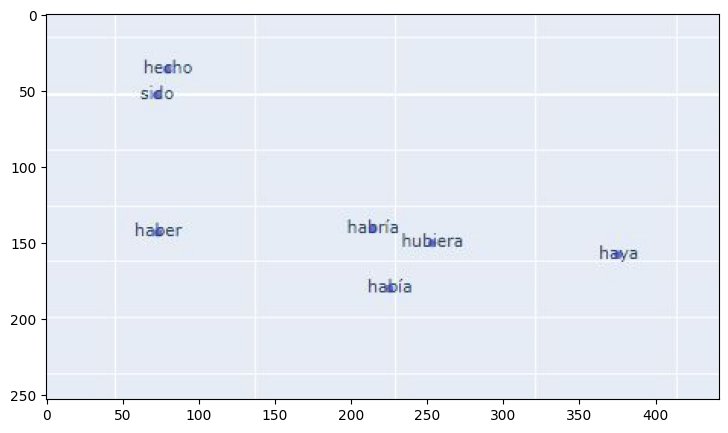

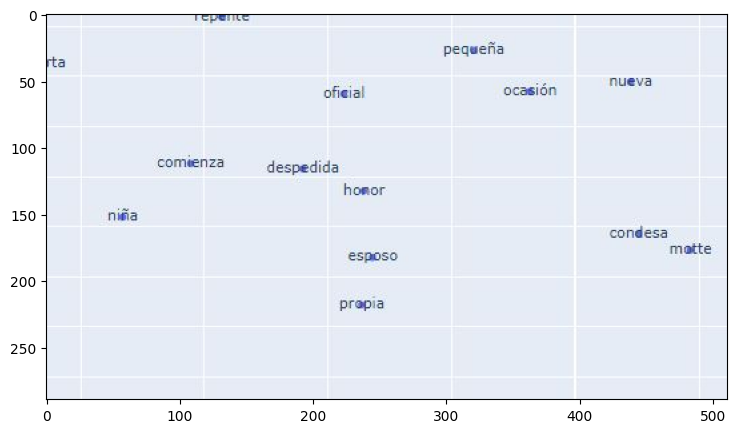

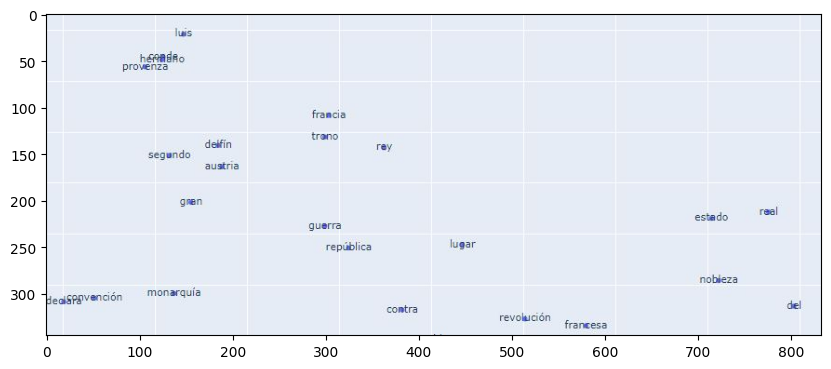

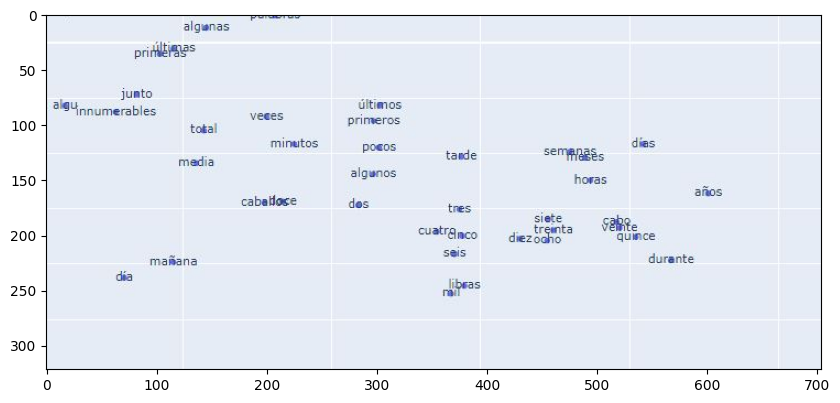

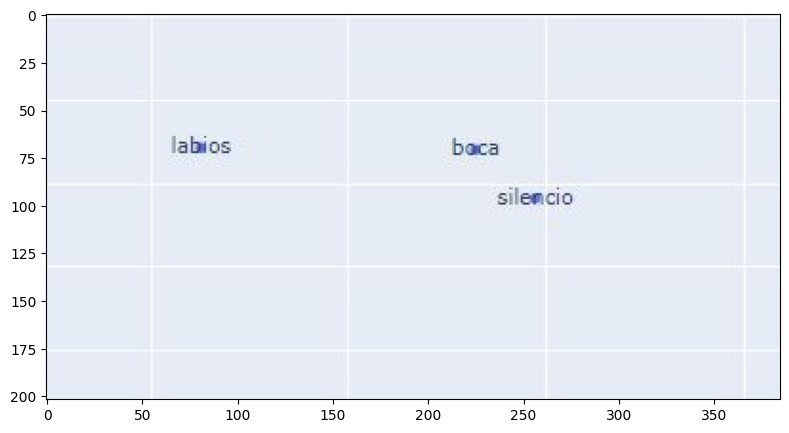

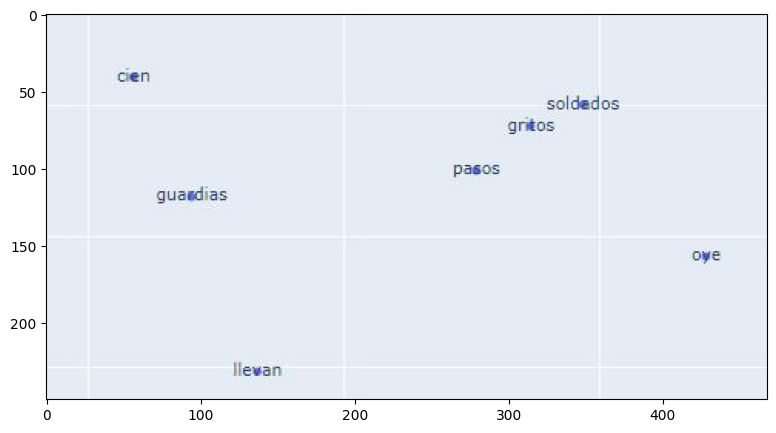

In [140]:
figs_root = './figuras'
figs = os.listdir(figs_root)

for f in figs:
  if f.endswith('JPG'):
    fig = plt.imread(os.path.join(figs_root,f))
    plt.figure(figsize=(10,5))
    plt.imshow(fig)
    plt.show()